In [214]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))
from corner_detector import *
from anms import *
from feat_match import *
from ransac_est_homography import *
from scipy import ndimage

max_anms=3000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
img1=cv2.imread('images/small-middle.jpg')
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X1,Y1,rmax=anms(c, max_anms)
d1 = feat_desc(gray,X1,Y1)
kp1=[]
for (_x,_y) in zip(X1,Y1):
    kp1.append(cv2.KeyPoint(_x,_y,40))


30178


In [216]:
img2=cv2.imread('images/small-right.jpg')
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X2,Y2,rmax=anms(c, max_anms)
d2 = feat_desc(gray,X2,Y2)
print("Rmax" + str(rmax))
kp2=[]
for (_x,_y) in zip(X2,Y2):
    kp2.append(cv2.KeyPoint(_x,_y,40))


37746
Rmax7.280109889280518


In [217]:
m,dMatch=feat_match(d1, d2)
x1=[]
y1=[]
x2=[]
y2=[]

for k,idx in enumerate(m):
    if (idx != -1):
        x1.append(X1[k])
        y1.append(Y1[k])
        x2.append(X2[idx])
        y2.append(Y2[idx])
x1=np.array(x1)
x2=np.array(x2)
y1=np.array(y1)
y2=np.array(y2)
print(x1.shape)


(22,)


In [228]:
H, inlier_ind=ransac_est_homography(x1,y1,x2,y2,5)

/home/nic/ms-work/cis581-3a/ransac_est_homography.py:58: RuntimeWarning: divide by zero encountered in true_divide
  vPtsPred = vPtsPred/vPtsPred[-1,:]
/home/nic/ms-work/cis581-3a/ransac_est_homography.py:58: RuntimeWarning: invalid value encountered in true_divide
  vPtsPred = vPtsPred/vPtsPred[-1,:]
/home/nic/ms-work/cis581-3a/ransac_est_homography.py:60: RuntimeWarning: invalid value encountered in less_equal
  inliers = 1*np.less_equal(distances,threshold)
(13,)
MaxInlierCount13
Final H[[-2.41 -0.56 997]
 [-1.18 -4.44 1.82e+03]
 [-0.00195 -0.00388 1]]


(1800, 2133, 3)
[[-2.41 -0.56 997]
 [-1.18 -4.44 1.82e+03]
 [-0.00195 -0.00388 1]]


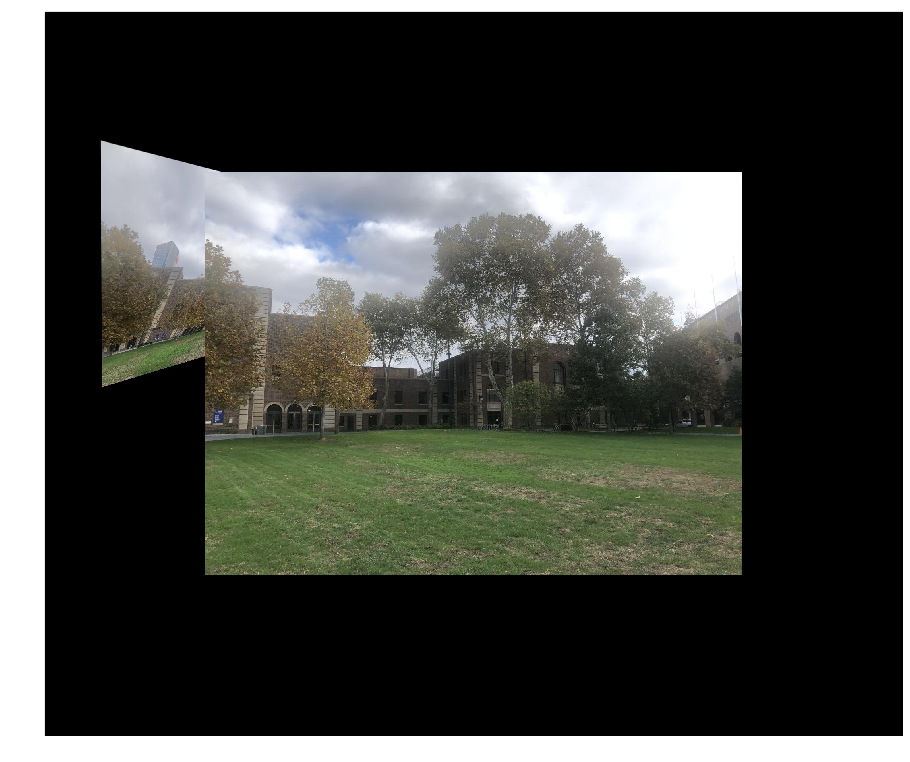

In [229]:

border = 400
paddedImage = cv2.copyMakeBorder(img1, border, border, border, border,cv2.BORDER_CONSTANT)
result = cv2.warpPerspective(paddedImage, H,(int(paddedImage.shape[1]), int(paddedImage.shape[0])))
result[border:border+img2.shape[0],border:border+img2.shape[1]] = img2
print(result.shape)
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
print(H)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()



In [ ]:
mask = np.array(inlier_ind, dtype=bool)

mfilter = []
for idx,i in enumerate(mask):
    if i == True:
        mfilter.append(dMatch[idx])
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
print(len(mfilter))
f=cv2.drawMatches(img1, kp1, img2, kp2, mfilter, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()
f=cv2.drawMatches(img1, kp1, img2, kp2, dMatch, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()

In [220]:
a = np.arange(12.).reshape((4, 3))
print(a)


[[0 1 2]
 [3 4 5]
 [6 7 8]
 [9 10 11]]


In [221]:
def panorama(H,fromim,toim,padding=2400,delta=2400):
    """ Create horizontal panorama by blending two images 
        using a homography H (preferably estimated using RANSAC).
        The result is an image with the same height as toim. 'padding' 
        specifies number of fill pixels and 'delta' additional translation. """
     
    # check if images are grayscale or color
    is_color = len(fromim.shape) == 3
     
    # homography transformation for geometric_transform()
    def transf(p):
        p2 = dot(H,[p[0],p[1],1])
        return (p2[0]/p2[2],p2[1]/p2[2])
     
    if H[1,2]<0: # fromim is to the right
        print('warp - right')
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding,3))))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                        transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the right
            toim_t = hstack((toim,zeros((toim.shape[0],padding))))
            fromim_t = ndimage.geometric_transform(fromim,transf,
                                    (toim.shape[0],toim.shape[1]+padding)) 
    else:
        print('warp - left')
        # add translation to compensate for padding to the left
        H_delta = array([[1,0,0],[0,1,-delta],[0,0,1]])
        H = dot(H,H_delta)
        # transform fromim
        if is_color:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding,3)),toim))
            fromim_t = zeros((toim.shape[0],toim.shape[1]+padding,toim.shape[2]))
            for col in range(3):
                fromim_t[:,:,col] = ndimage.geometric_transform(fromim[:,:,col],
                                            transf,(toim.shape[0],toim.shape[1]+padding))
        else:
            # pad the destination image with zeros to the left
            toim_t = hstack((zeros((toim.shape[0],padding)),toim))
            fromim_t = ndimage.geometric_transform(fromim,
                                    transf,(toim.shape[0],toim.shape[1]+padding))
     
    # blend and return (put fromim above toim)
    if is_color:
        # all non black pixels
        alpha = ((fromim_t[:,:,0] * fromim_t[:,:,1] * fromim_t[:,:,2] ) > 0)
        for col in range(3):
            toim_t[:,:,col] = fromim_t[:,:,col]*alpha + toim_t[:,:,col]*(1-alpha)
    else:
        alpha = (fromim_t > 0)
        toim_t = fromim_t*alpha + toim_t*(1-alpha)
     
    return toim_t

In [222]:
res=panorama(H,img1,img2)

warp - left


In [223]:
print(res.shape)

(1000, 3733, 3)


In [224]:
h1 = img1.shape[0]
h2 = img2.shape[0]
w1 = img1.shape[1]
w2 = img2.shape[1]
vis = np.zeros((max(h1, h2), w1+w2,3), np.uint8)

#combine 2 images
vis[:h1, :w1,:3] = img1
vis[:h2, w1:w1+w2,:3] = img2

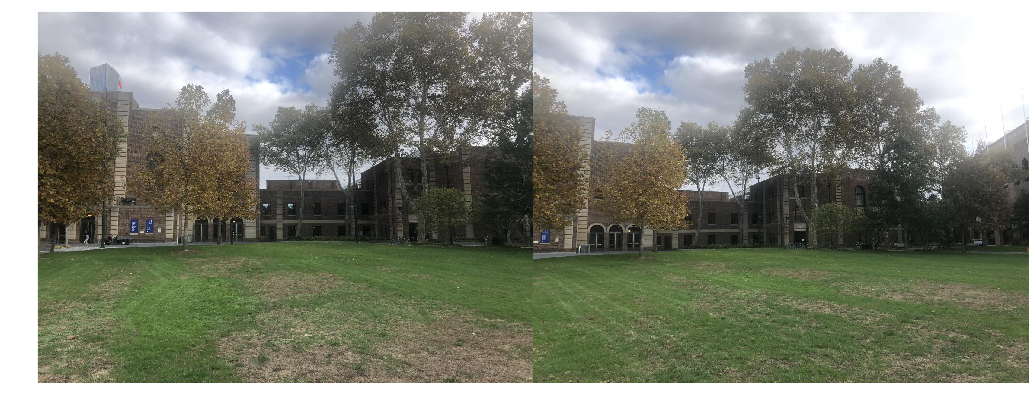

In [225]:
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))